In [1]:
cd ..

/Users/warsameyusuf/Documents/Masters/Research project/Git files BLL/chime_sims


In [2]:
import pandas as pd
from os import getcwd, path, sys
from _99_shared_functions import *
import matplotlib.pyplot as plt
from scipy import stats as sps

import sys
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

# For getting the last folder containing hospital name
def get_all_folders(path):
    return [x for x in os.listdir(path) if os.path.isfile(x) == False]

# Get parameters from files stored during step 1, don't get from args (one argument, directory)
datadir = path.join(f'{getcwd()}', 'data')
outdir = path.join(f'{getcwd()}', 'output')
lastdir = path.join(f'{get_all_folders(outdir)[-1]}')
outdir = path.join(f'{lastdir}', 'output')
figdir = path.join(f'{lastdir}', 'figures')


hospital = 'OTT'

census_ts = pd.read_csv(path.join(f"{datadir}",f"{hospital}_ts.csv"))
first_day = census_ts['date'].values[0]
params = pd.read_csv(path.join(f"{datadir}",f"{hospital}_parameters.csv"))
# impute vent with the proportion of hosp.  this is a crude hack
census_ts.loc[census_ts.vent.isna(), 'vent'] = census_ts.hosp.loc[census_ts.vent.isna()]*np.mean(census_ts.vent/census_ts.hosp)

# This needs to be configuable based on the time period specificed 
nobs = census_ts.shape[0]

# define capacity
vent_capacity = float(params.base.loc[params.param == 'vent_capacity'])
hosp_capacity = float(params.base.loc[params.param == 'hosp_capacity'])

# Chains
df = pd.read_json(path.join('output',f"{outdir}","chains.json.bz2"), lines = True)

# remove burn-in
# Make 1000 configurable
df = df.loc[(df.iter>1000)] #& (~df.chain.isin([1, 12]))]

In [3]:
def plt_predictive_panel(arrq, column, label, dates, howfar,  axx):
    axx.plot_date(dates, arrq[2,:howfar, column], '-', label = 'posterior median')
    axx.set_ylabel(label, fontsize=12, fontweight='bold')
    axx.fill_between(x = dates,
                       y1 = arrq[0,:howfar,column],
                       y2 = arrq[4,:howfar,column], 
                       label = '90% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.fill_between(x = dates,
                       y1 = arrq[1,:howfar,column],
                       y2 = arrq[3,:howfar,column], 
                       label = '50% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.legend()
    axx.grid(True)

def plt_predictive(howfar=200, df = df):
    # predictive plot
    arrs = np.stack([df.arr.iloc[i] for i in range(df.shape[0])])
    arrq = np.quantile(arrs, axis = 0, q = [.05, .25, .5, .75, .95])

    dates = pd.date_range(f'{first_day}',
        periods=howfar, freq='d')
    fig, ax = plt.subplots(figsize=(16, 10), ncols=2, nrows=2, sharex=True)
    
    # hosp
    axx = ax[0,0]
    plt_predictive_panel(arrq, 3, "COVID-19 Hospital census", dates, howfar,  axx)
    axx.axhline(y=hosp_capacity, color='k', ls='--', label = "hospital capacity")
    axx.plot_date(dates[:census_ts.hosp.shape[0]], census_ts.hosp, '-',
               color = "red",
               label = "observed")

    axx = ax[0,1]
    plt_predictive_panel(arrq, 5, "COVID-19 Vent census", dates, howfar,  axx)
    axx.axhline(y=vent_capacity, color='k', ls='--', label = "vent capacity")
    axx.plot_date(dates[:census_ts.vent.shape[0]], census_ts.vent, '-',
               color = "red",
               label = "observed")
    axx.legend()
    axx.grid(True)

    # Admits
    axx = ax[1,0]
    plt_predictive_panel(arrq, 0, "COVID-19 Hospital Admits", dates, howfar,  axx)

    axx = ax[1,1]
    plt_predictive_panel(arrq, 2, "COVID-19 Vent Admits", dates, howfar,  axx)
    fig.autofmt_xdate()
    fig.tight_layout()

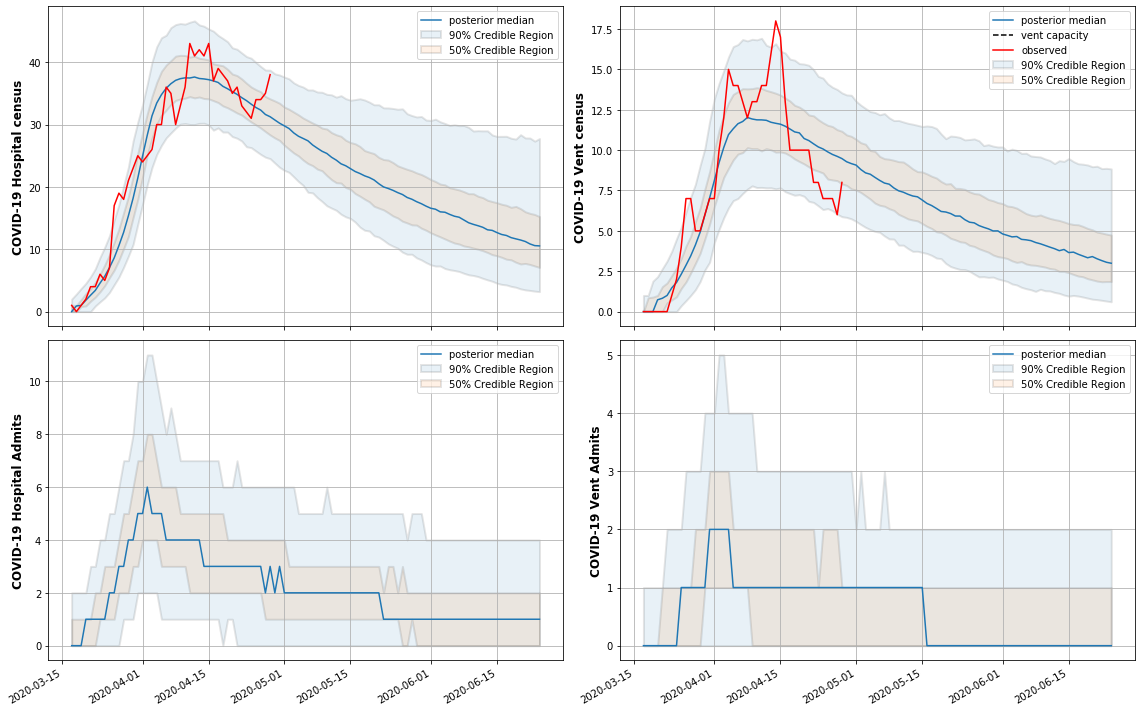

In [4]:
plt_predictive(100, df = df)

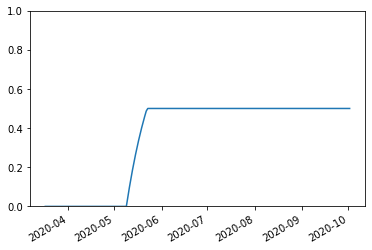

In [5]:
def reopenfn(day, reopen_day=60, reopen_speed=0.1, sd_max =0.5):
    sd_max = 1 - sd_max
    if day < reopen_day:
        return 1.0
    else:
        ret = (1-reopen_speed)**(day-reopen_day)
        if ret < sd_max: 
            ret = sd_max
        return ret
    
df['reopen_speed'] = 0.05
df['reopen_day'] = 39 + 14
howfar = 200
days = range(howfar)
dates = pd.date_range(f'{first_day}',
        periods=howfar, freq='d')
remove_sd = [1-reopenfn(day, df['reopen_day'].values[0], df['reopen_speed'].values[0]) for day in days]
fig, ax = plt.subplots(1,1)
ax.plot(dates, remove_sd)
ax.set_ylim(0,1)
fig.autofmt_xdate()

In [6]:
reopen_sims = {}
reopen_on_days = [14,28,42]
for reopen_on in reopen_on_days:
    df['reopen_day'] = 39 + reopen_on # begin reopening in reopen_on days from now
    df['reopen_speed'] = 0.05
    df.index = range(df.shape[0])
    ddf = df.T.reset_index()

    sims = []
    idx_samples = np.random.choice([i for i in df.index], 4000)
    for param_col in idx_samples:
        p_df = ddf[['index', param_col]].rename(columns={'index': 'param', param_col: 'val'})
        sim = SIR_from_params(p_df, sd_max=0.86)
        sims.append(sim)
    df_reopen = pd.DataFrame(sims)
    reopen_sims[reopen_on] = df_reopen
    print(reopen_on)

14
28
42


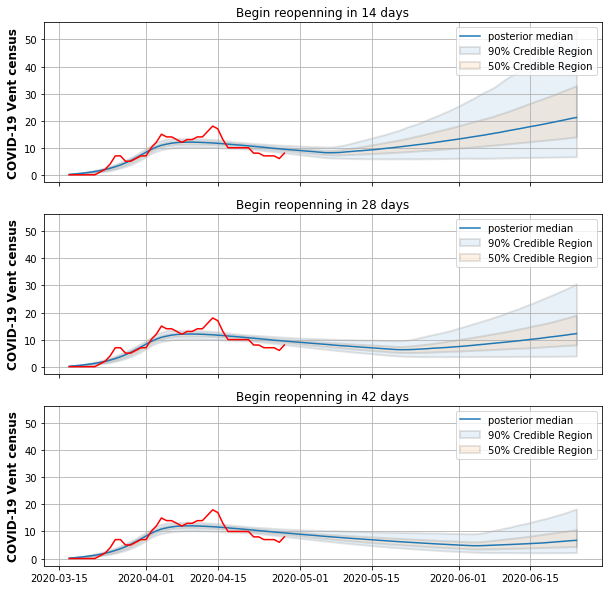

In [7]:
def plt_vent(df, howfar, ax):
    arrs = np.stack([df.arr.iloc[i] for i in range(df.shape[0])])
    arrq = np.quantile(arrs, axis = 0, q = [.05, .25, .5, .75, .95])

    dates = pd.date_range(f'{first_day}',
        periods=howfar, freq='d')
    plt_predictive_panel(arrq, 5, "COVID-19 Vent census", dates, howfar,  ax)
    axx.plot_date(dates[:census_ts.vent.shape[0]], census_ts.vent, '-',
               color = "red",
               label = "observed")
    axx.axhline(y=vent_capacity, color='k', ls='--', label = "vent capacity")


reopen_on_days = [14,28,42]
fig, ax = plt.subplots(figsize=(10, 10), ncols=1, nrows=len(reopen_on_days), sharex=True, sharey=True)
for i, reopen_on in enumerate(reopen_on_days):
    axx = ax[i]
    plt_vent(reopen_sims[reopen_on], 200, axx)
    axx.set_title(f"Begin reopening in {reopen_on} days")
plt.show()

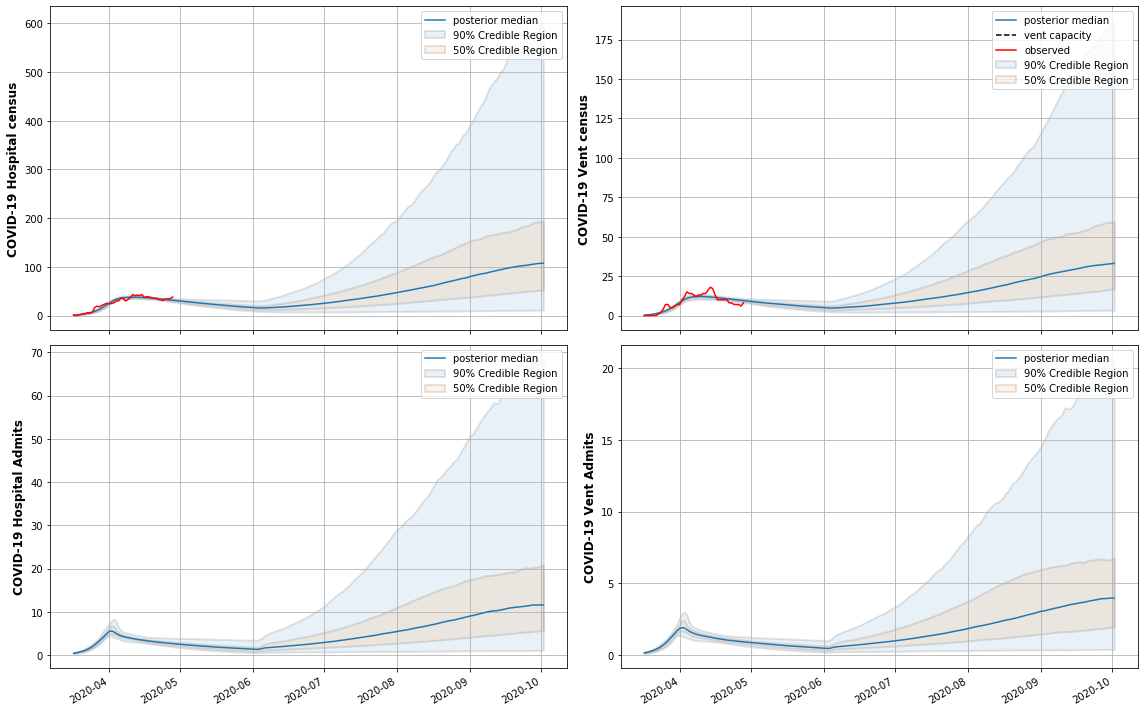

In [8]:
plt_predictive(200, df = df_reopen)